The aim of this project is to predict bookings that will be canceled.

It consists of two steps: preprocessing and modelling

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display_html
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

In [ ]:
h1 = pd.read_csv("sample_data/H1.csv") 
h2 = pd.read_csv("sample_data/H2.csv") 
h1.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,342,2015,July,27,1,0,0,2,0,...,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,0,737,2015,July,27,1,0,0,2,0,...,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,0,7,2015,July,27,1,0,1,1,0,...,No Deposit,NULL,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,0,13,2015,July,27,1,0,1,1,0,...,No Deposit,304,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,0,14,2015,July,27,1,0,2,2,0,...,No Deposit,240,NULL,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [ ]:
h1.loc[:, 'id'] = range(1, len(h1) + 1)

start = h1['id'].max() + 1
stop = start + len(h2)
h2.loc[:, 'id'] = range(start, stop)

df = pd.concat([h1, h2], ignore_index=True, sort=False)
df.columns[:3]

Index(['IsCanceled', 'LeadTime', 'ArrivalDateYear'], dtype='object')

Converting to snake case

In [ ]:
def convert(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

columns = [convert(col) for col in df.columns]
df.columns = columns

Descriptive statistics


In [ ]:
df.shape

(119390, 32)

In [ ]:
df.loc[0]

is_canceled                                      0
lead_time                                      342
arrival_date_year                             2015
arrival_date_month                            July
arrival_date_week_number                        27
arrival_date_day_of_month                        1
stays_in_weekend_nights                          0
stays_in_week_nights                             0
adults                                           2
children                                       0.0
babies                                           0
meal                                     BB       
country                                        PRT
market_segment                              Direct
distribution_channel                        Direct
is_repeated_guest                                0
previous_cancellations                           0
previous_bookings_not_canceled                   0
reserved_room_type                C               
assigned_room_type             

In [ ]:
df.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,id
0,0,342,2015,July,27,1,0,0,2,0.0,...,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01,1
1,0,737,2015,July,27,1,0,0,2,0.0,...,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01,2
2,0,7,2015,July,27,1,0,1,1,0.0,...,NULL,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02,3
3,0,13,2015,July,27,1,0,1,1,0.0,...,304,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02,4
4,0,14,2015,July,27,1,0,2,2,0.0,...,240,NULL,0,Transient,98.0,0,1,Check-Out,2015-07-03,5


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     119390 non-null  int64  
 1   lead_time                       119390 non-null  int64  
 2   arrival_date_year               119390 non-null  int64  
 3   arrival_date_month              119390 non-null  object 
 4   arrival_date_week_number        119390 non-null  int64  
 5   arrival_date_day_of_month       119390 non-null  int64  
 6   stays_in_weekend_nights         119390 non-null  int64  
 7   stays_in_week_nights            119390 non-null  int64  
 8   adults                          119390 non-null  int64  
 9   children                        119386 non-null  float64
 10  babies                          119390 non-null  int64  
 11  meal                            119390 non-null  object 
 12  country         

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
is_canceled,119390.0,0.370416,0.482918,0.00,0.00,0.000,1.00,1.0
lead_time,119390.0,104.011416,106.863097,0.00,18.00,69.000,160.00,737.0
arrival_date_year,119390.0,2016.156554,0.707476,2015.00,2016.00,2016.000,2017.00,2017.0
arrival_date_week_number,119390.0,27.165173,13.605138,1.00,16.00,28.000,38.00,53.0
arrival_date_day_of_month,119390.0,15.798241,8.780829,1.00,8.00,16.000,23.00,31.0
stays_in_weekend_nights,119390.0,0.927599,0.998613,0.00,0.00,1.000,2.00,19.0
stays_in_week_nights,119390.0,2.500302,1.908286,0.00,1.00,2.000,3.00,50.0
adults,119390.0,1.856403,0.579261,0.00,2.00,2.000,2.00,55.0
children,119386.0,0.103890,0.398561,0.00,0.00,0.000,0.00,10.0
babies,119390.0,0.007949,0.097436,0.00,0.00,0.000,0.00,10.0


In [ ]:
print('meal : ',df.meal.unique())
print('countries: ',df.country.unique())
print('customer type: ', df.customer_type.unique())

meal :  ['BB       ' 'FB       ' 'HB       ' 'SC       ' 'Undefined']
countries:  ['PRT' 'GBR' 'USA' 'ESP' 'IRL' 'FRA' nan 'ROU' 'NOR' 'OMN' 'ARG' 'POL'
 'DEU' 'BEL' 'CHE' 'CN' 'GRC' 'ITA' 'NLD' 'DNK' 'RUS' 'SWE' 'AUS' 'EST'
 'CZE' 'BRA' 'FIN' 'MOZ' 'BWA' 'LUX' 'SVN' 'ALB' 'IND' 'CHN' 'MEX' 'MAR'
 'UKR' 'SMR' 'LVA' 'PRI' 'SRB' 'CHL' 'AUT' 'BLR' 'LTU' 'TUR' 'ZAF' 'AGO'
 'ISR' 'CYM' 'ZMB' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN' 'ARE' 'TUN' 'JAM'
 'HRV' 'HKG' 'IRN' 'GEO' 'AND' 'GIB' 'URY' 'JEY' 'CAF' 'CYP' 'COL' 'GGY'
 'KWT' 'NGA' 'MDV' 'VEN' 'SVK' 'FJI' 'KAZ' 'PAK' 'IDN' 'LBN' 'PHL' 'SEN'
 'SYC' 'AZE' 'BHR' 'NZL' 'THA' 'DOM' 'MKD' 'MYS' 'ARM' 'JPN' 'LKA' 'CUB'
 'CMR' 'BIH' 'MUS' 'COM' 'SUR' 'UGA' 'BGR' 'CIV' 'JOR' 'SYR' 'SGP' 'BDI'
 'SAU' 'VNM' 'PLW' 'QAT' 'EGY' 'PER' 'MLT' 'MWI' 'ECU' 'MDG' 'ISL' 'UZB'
 'NPL' 'BHS' 'MAC' 'TGO' 'TWN' 'DJI' 'STP' 'KNA' 'ETH' 'IRQ' 'HND' 'RWA'
 'KHM' 'MCO' 'BGD' 'IMN' 'TJK' 'NIC' 'BEN' 'VGB' 'TZA' 'GAB' 'GHA' 'TMP'
 'GLP' 'KEN' 'LIE' 'GNB' 'MNE' 'UMI' 'MYT' 'F

Checking for null values

In [ ]:
df.groupby('company') \
    .size() \
    .reset_index() \
    .rename(columns={0: 'bookings'}) \
    .sort_values(by='bookings', ascending=False)

,company,bookings
352,NULL,112593
20,40,927
131,223,784
37,67,267
23,45,250
...,...,...
172,284,1
175,288,1
281,425,1
1,8,1


In [ ]:
df.groupby('agent') \
    .size() \
    .reset_index() \
    .rename(columns={0: 'bookings'}) \
    .sort_values(by='bookings', ascending=False)

,agent,bookings
8,9,31961
333,NULL,16340
173,240,13922
0,1,7191
13,14,3640
...,...,...
200,280,1
298,444,1
299,446,1
199,278,1


## Preprocessing

In [ ]:
#Convert NULL or Undefined string to np.nan
for col in df.columns:
    if df[col].dtype == 'object' and col != 'country':
        df.loc[df[col].str.contains('NULL'), col] = np.nan
        df.loc[df[col].str.contains('Undefined', na=False), col] = np.nan

In [ ]:
df.isnull().sum()

is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                1169
country                              488
market_segment                         2
distribution_channel                   5
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company                           112593
days_in_waiting_

In [ ]:
#deleting columns with missing values
subset = [
    'country', 
    'children', 
    'market_segment', 
    'distribution_channel',
]
df.dropna(subset=subset, inplace=True)

In [ ]:
# Filling missing values with default values
df.loc[df.agent.isnull(), 'agent'] = '999'
df.loc[df.company.isnull(), 'company'] = 999
df.loc[df.meal.isnull(), 'meal'] = 'SC'

## Cleaning wrong values

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
is_canceled,116958.0,0.375776,0.484325,0.00,0.00,0.0,1.00,1.0
lead_time,116958.0,105.376297,106.944554,0.00,19.00,71.0,162.00,709.0
arrival_date_year,116958.0,2016.161451,0.706501,2015.00,2016.00,2016.0,2017.00,2017.0
arrival_date_week_number,116958.0,27.137981,13.561225,1.00,16.00,27.0,38.00,53.0
arrival_date_day_of_month,116958.0,15.805221,8.783034,1.00,8.00,16.0,23.00,31.0
stays_in_weekend_nights,116958.0,0.937670,0.993328,0.00,0.00,1.0,2.00,16.0
stays_in_week_nights,116958.0,2.522957,1.885579,0.00,1.00,2.0,3.00,41.0
adults,116958.0,1.862438,0.481129,0.00,2.00,2.0,2.00,4.0
children,116958.0,0.104815,0.400288,0.00,0.00,0.0,0.00,10.0
babies,116958.0,0.007866,0.097102,0.00,0.00,0.0,0.00,10.0


In [ ]:
# taking records with adr >0
df = df[df.adr > 0]

## Outlier detection

In [ ]:
# IQR
cleaned = df.copy()

columns = [
    'lead_time',
    'stays_in_weekend_nights',
    'stays_in_week_nights',
    'adults',
    'children',
    'babies',
    'adr',
]

for col in columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)

    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    print(f'Lower point: {round(lower, 2)} \t upper point: {round(upper, 2)} \t {col}')
    
    if lower == upper:
        continue
    
    cond1 = (cleaned[col] >= lower) & (cleaned[col] <= upper)
    cond2 = cleaned[col].isnull()
    cleaned = cleaned[cond1 | cond2]

Lower point: -195.5 	 upper point: 376.5 	 lead_time
Lower point: -3.0 	 upper point: 5.0 	 stays_in_weekend_nights
Lower point: -2.0 	 upper point: 6.0 	 stays_in_week_nights
Lower point: 2.0 	 upper point: 2.0 	 adults
Lower point: 0.0 	 upper point: 0.0 	 children
Lower point: 0.0 	 upper point: 0.0 	 babies
Lower point: -11.5 	 upper point: 208.5 	 adr


In [ ]:
cleaned[columns].describe().T

,count,mean,std,min,25%,50%,75%,max
lead_time,106723.0,96.088406,92.822540,0.0,18.0,67.0,152.00,374.0
stays_in_weekend_nights,106723.0,0.865062,0.870129,0.0,0.0,1.0,2.00,4.0
stays_in_week_nights,106723.0,2.318029,1.415296,0.0,1.0,2.0,3.00,6.0
adults,106723.0,1.848083,0.482426,0.0,2.0,2.0,2.00,4.0
children,106723.0,0.083815,0.350265,0.0,0.0,0.0,0.00,3.0
babies,106723.0,0.007534,0.095824,0.0,0.0,0.0,0.00,10.0
adr,106723.0,99.155196,38.421950,1.0,71.1,94.8,123.14,208.5


## Multivariate Anomaly Detection
Some observations may not be outlier when alone. However, when combined with another variable, outlier values may occur <br>
For example, with the price - nights,
70 euro is not a normal price for 7 nights

In [ ]:
# thats not important, just for visualization
def display_side_by_side(*args):
    html_str = ''
    
    for df in args:
        html_str += df.to_html()
        
    display_html(html_str.replace('table', 'table style="display:inline"'), raw=True)
cleaned.loc[:, 'total_nights'] = cleaned['stays_in_week_nights'] + cleaned['stays_in_weekend_nights']
cleaned.loc[:, 'price'] = cleaned['adr'] * cleaned['total_nights']
cols = ['total_nights', 'price']
# convert to numpy array, because local outlier method want this
X = np.array(cleaned[cols])

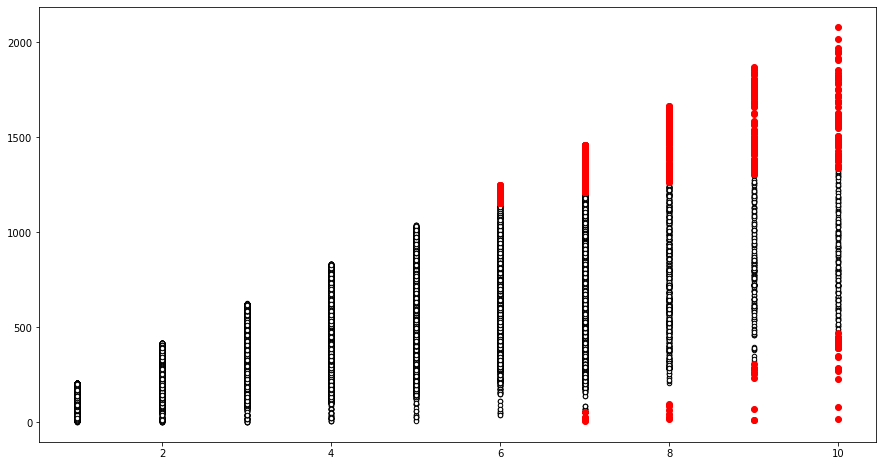

In [ ]:
# Removing outliers using ecliptic envelope
# create model
ee = EllipticEnvelope(contamination=.01, random_state=0)
# predictions
y_pred_ee = ee.fit_predict(X)
# predictions (-1: outlier, 1: normal)
anomalies = X[y_pred_ee == -1]
# plot data and outliers
plt.figure(figsize=(15, 8))
plt.scatter(X[:, 0], X[:, 1], c='white', s=20, edgecolor='k')
plt.scatter(anomalies[:, 0], anomalies[:, 1], c='red');

In [ ]:
# statistics of outlier observations
outliers = cleaned[y_pred_ee == -1][cols] \
    .groupby(cols[0]) \
    .agg({cols[1]: ['min', 'max', 'mean', 'std', 'median']})
# statistics of all observations
all_data = cleaned[cols] \
    .groupby(cols[0]) \
    .agg({cols[1]: ['min', 'max', 'mean', 'std', 'median']})
# statistics of cleaned data
clean_data = cleaned[y_pred_ee != -1] \
    .groupby(cols[0]) \
    .agg({cols[1]: ['min', 'max', 'mean', 'std', 'median']})
display_side_by_side(all_data, outliers, clean_data)

price 
 
 
 
 min 
 max 
 mean 
 std 
 median 
 
 
 total_nights 
 
 
 
 
 
 
 
 
 
 1 
 1.00 
 208.00 
 93.551632 
 40.041280 
 89.000 
 
 
 2 
 2.00 
 417.00 
 193.363506 
 71.809371 
 187.200 
 
 
 3 
 3.00 
 624.99 
 307.502708 
 108.518262 
 291.600 
 
 
 4 
 4.00 
 834.00 
 402.891749 
 149.940802 
 384.200 
 
 
 5 
 8.00 
 1040.00 
 528.015487 
 196.280852 
 501.500 
 
 
 6 
 36.00 
 1249.02 
 655.874750 
 249.239448 
 635.550 
 
 
 7 
 9.03 
 1459.36 
 666.379208 
 305.362646 
 598.500 
 
 
 8 
 16.00 
 1664.16 
 832.900760 
 362.480690 
 795.600 
 
 
 9 
 14.04 
 1867.50 
 1002.631601 
 409.619361 
 909.765 
 
 
 10 
 18.00 
 2082.00 
 993.092523 
 418.914945 
 921.000 
 
 
 
 
 
 
 price 
 
 
 
 min 
 max 
 mean 
 std 
 median 
 
 
 total_nights 
 
 
 
 
 
 
 
 
 
 6 
 1152.00 
 1249.02 
 1196.127231 
 28.867197 
 1193.04 
 
 
 7 
 9.03 
 1459.36 
 1314.514600 
 142.000417 
 1320.48 
 
 
 8 
 16.00 
 1664.16 
 1400.684800 
 299.490422 
 1450.00 
 
 
 9 
 14.04 
 1867.50 
 1413.963679 
 445.921108 
 1480.50 
 
 
 10 
 18.00 
 2082.00 
 1267.973000 
 584.023093 
 1474.75 
 
 
 
 
 
 
 price 
 
 
 
 min 
 max 
 mean 
 std 
 median 
 
 
 total_nights 
 
 
 
 
 
 
 
 
 
 1 
 1.0 
 208.00 
 93.551632 
 40.041280 
 89.00 
 
 
 2 
 2.0 
 417.00 
 193.363506 
 71.809371 
 187.20 
 
 
 3 
 3.0 
 624.99 
 307.502708 
 108.518262 
 291.60 
 
 
 4 
 4.0 
 834.00 
 402.891749 
 149.940802 
 384.20 
 
 
 5 
 8.0 
 1040.00 
 528.015487 
 196.280852 
 501.50 
 
 
 6 
 36.0 
 1150.02 
 634.897204 
 229.617591 
 621.00 
 
 
 7 
 56.0 
 1210.02 
 618.868283 
 256.030785 
 573.02 
 
 
 8 
 208.8 
 1260.88 
 738.479911 
 275.387665 
 720.00 
 
 
 9 
 324.0 
 1296.00 
 828.226800 
 229.781849 
 801.90 
 
 
 10 
 480.0 
 1322.40 
 868.712217 
 227.781794 
 840.00

### Local outlier factor

In [ ]:
# create model
lof = LocalOutlierFactor(contamination=.001)
# predictions
y_pred_lof = lof.fit_predict(X)

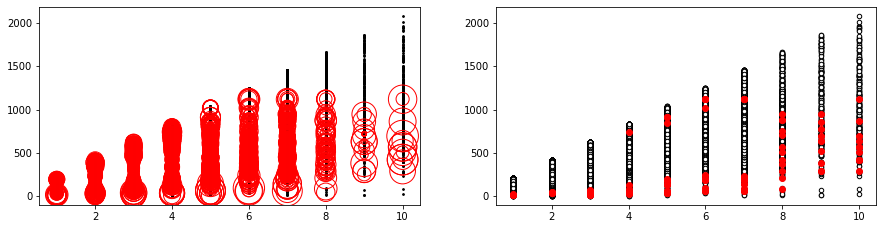

In [ ]:
# predictions (-1: outlier, 1: normal)
anomalies = X[y_pred_lof == -1]
# radius for red circles
X_score = lof.negative_outlier_factor_
radius = (X_score.max() - X_score) / (X_score.max() - X_score.min())
# plot circles and outlier observations
plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
plt.scatter(X[:, 0], X[:, 1], color='k', s=3);
plt.scatter(X[:, 0], X[:, 1], s=1000 * radius, edgecolors='r', facecolors='none')

plt.subplot(2, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c='white', s=20, edgecolor='k')
plt.scatter(anomalies[:, 0], anomalies[:,1], c='red');

In [ ]:
# statistics of outlier observations
outliers = cleaned[y_pred_lof == -1][cols] \
    .groupby(cols[0]) \
    .agg({cols[1]: ['min', 'max', 'mean', 'std', 'median']})
# statistics of all observations
all_data = cleaned[cols] \
    .groupby(cols[0]) \
    .agg({cols[1]: ['min', 'max', 'mean', 'std', 'median']})
# statistics of cleaned data
clean_data = cleaned[y_pred_lof != -1] \
    .groupby(cols[0]) \
    .agg({cols[1]: ['min', 'max', 'mean', 'std', 'median']})
display_side_by_side(all_data, outliers, clean_data)

price 
 
 
 
 min 
 max 
 mean 
 std 
 median 
 
 
 total_nights 
 
 
 
 
 
 
 
 
 
 1 
 1.00 
 208.00 
 93.551632 
 40.041280 
 89.000 
 
 
 2 
 2.00 
 417.00 
 193.363506 
 71.809371 
 187.200 
 
 
 3 
 3.00 
 624.99 
 307.502708 
 108.518262 
 291.600 
 
 
 4 
 4.00 
 834.00 
 402.891749 
 149.940802 
 384.200 
 
 
 5 
 8.00 
 1040.00 
 528.015487 
 196.280852 
 501.500 
 
 
 6 
 36.00 
 1249.02 
 655.874750 
 249.239448 
 635.550 
 
 
 7 
 9.03 
 1459.36 
 666.379208 
 305.362646 
 598.500 
 
 
 8 
 16.00 
 1664.16 
 832.900760 
 362.480690 
 795.600 
 
 
 9 
 14.04 
 1867.50 
 1002.631601 
 409.619361 
 909.765 
 
 
 10 
 18.00 
 2082.00 
 993.092523 
 418.914945 
 921.000 
 
 
 
 
 
 
 price 
 
 
 
 min 
 max 
 mean 
 std 
 median 
 
 
 total_nights 
 
 
 
 
 
 
 
 
 
 1 
 10.80 
 24.00 
 15.450000 
 5.854628 
 13.500 
 
 
 2 
 28.00 
 48.00 
 35.200000 
 9.230385 
 30.000 
 
 
 3 
 6.00 
 72.00 
 36.950000 
 22.179290 
 39.000 
 
 
 4 
 27.60 
 741.20 
 127.466667 
 232.550640 
 32.000 
 
 
 5 
 30.00 
 910.00 
 284.825000 
 367.392949 
 92.775 
 
 
 6 
 54.00 
 1121.40 
 543.595000 
 495.048463 
 222.270 
 
 
 7 
 54.60 
 1121.40 
 384.291250 
 442.566490 
 188.755 
 
 
 8 
 84.00 
 945.04 
 548.086667 
 283.577293 
 535.880 
 
 
 9 
 286.92 
 945.90 
 600.525000 
 230.479476 
 630.000 
 
 
 10 
 288.00 
 1119.60 
 590.509091 
 235.271594 
 567.000 
 
 
 
 
 
 
 price 
 
 
 
 min 
 max 
 mean 
 std 
 median 
 
 
 total_nights 
 
 
 
 
 
 
 
 
 
 1 
 1.00 
 208.00 
 93.567720 
 40.029642 
 89.00 
 
 
 2 
 2.00 
 417.00 
 193.395204 
 71.781551 
 187.20 
 
 
 3 
 3.00 
 624.99 
 307.631018 
 108.382895 
 291.60 
 
 
 4 
 4.00 
 834.00 
 403.042108 
 149.755922 
 384.52 
 
 
 5 
 8.00 
 1040.00 
 528.551370 
 195.452226 
 501.50 
 
 
 6 
 36.00 
 1249.02 
 656.263485 
 248.019389 
 635.85 
 
 
 7 
 9.03 
 1459.36 
 666.940786 
 304.807564 
 598.50 
 
 
 8 
 16.00 
 1664.16 
 836.187077 
 362.092116 
 797.24 
 
 
 9 
 14.04 
 1867.50 
 1014.253179 
 407.974964 
 933.21 
 
 
 10 
 18.00 
 2082.00 
 1007.377742 
 417.098617 
 939.20

In [ ]:
df_cleaned = cleaned[y_pred_ee != -1].copy()
h1_cleaned = df_cleaned[df_cleaned.id.isin(h1.id.tolist())]
h2_cleaned = df_cleaned[df_cleaned.id.isin(h2.id.tolist())]

h1_cleaned = h1_cleaned.drop('id', axis=1)
h2_cleaned = h2_cleaned.drop('id', axis=1)
h1_cleaned.to_csv('./sample_data/H1_cleaned.csv', index=False)
h2_cleaned.to_csv('./sample_data/H2_cleaned.csv', index=False)

# Modelling

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
train = h1_cleaned
test = h2_cleaned

In [ ]:
train['is_canceled'].value_counts()

0    23720
1     8697
Name: is_canceled, dtype: int64

In [ ]:
test['is_canceled'].value_counts()

0    43137
1    30133
Name: is_canceled, dtype: int64

## Feature Engineering

In [ ]:
df_le.agent.unique()

array([999, '        304', '        240', '        303', '         15',
       '        241', '          8', '        250', '        115',
       '          5', '        175', '        134', '        156',
       '        243', '        242', '          3', '        105',
       '        147', '         40', '        306', '        184',
       '         96', '          2', '        127', '         95',
       '        146', '          9', '        177', '          6',
       '        143', '        244', '        149', '        167',
       '        300', '        171', '        305', '         67',
       '        196', '        152', '        142', '        261',
       '        104', '         36', '         26', '        258',
       '        110', '         71', '        181', '         88',
       '        251', '        275', '        248', '        208',
       '         69', '        256', '        314', '        126',
       '        281', '        273', '        330', '    

In [ ]:
df_le.replace(to_replace= 999, value = '999', inplace=True )
df_le

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,total_nights,price
2,0,7,2015,5,27,1,0,1,1,0.0,...,999,0,Transient,75.00,0,0,Check-Out,2015-07-02,1,75.0
3,0,13,2015,5,27,1,0,1,1,0.0,...,999,0,Transient,75.00,0,0,Check-Out,2015-07-02,1,75.0
4,0,14,2015,5,27,1,0,2,2,0.0,...,999,0,Transient,98.00,0,1,Check-Out,2015-07-03,2,196.0
5,0,14,2015,5,27,1,0,2,2,0.0,...,999,0,Transient,98.00,0,1,Check-Out,2015-07-03,2,196.0
6,0,0,2015,5,27,1,0,2,2,0.0,...,999,0,Transient,107.00,0,0,Check-Out,2015-07-03,2,214.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40035,0,21,2017,1,35,31,2,5,2,0.0,...,999,0,Contract,101.70,0,2,Check-Out,2017-09-07,7,711.9
40036,0,279,2017,1,35,31,2,5,2,0.0,...,999,0,Contract,72.20,0,1,Check-Out,2017-09-07,7,505.4
40038,0,191,2017,1,35,31,2,5,2,0.0,...,999,0,Contract,114.80,0,0,Check-Out,2017-09-07,7,803.6
40041,0,227,2017,1,35,31,2,5,2,1.0,...,999,0,Transient,127.58,0,1,Check-Out,2017-09-07,7,893.06


In [ ]:
df_le = train.copy()
le = LabelEncoder()

categoricals = [
    'arrival_date_month',
    'meal',
    'country',
    'market_segment',
    'distribution_channel',
    'reserved_room_type',
    'assigned_room_type',
    'deposit_type',
    'agent',
    'company',
    'customer_type',
    'reservation_status',
]

# df2 = df2.apply(lambda col: le.fit_transform(col.astype(str)), axis=0, result_type='expand')

for col in categoricals:
    print(col)
    df_le[col] = le.fit_transform(df_le[col].astype(str))

arrival_date_month
meal
country
market_segment
distribution_channel
reserved_room_type
assigned_room_type
deposit_type
agent
company
customer_type
reservation_status


In [ ]:
df_le.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,total_nights,price
2,0,7,2015,5,27,1,0,1,1,0.0,...,224,0,2,75.0,0,0,1,2015-07-02,1,75.0
3,0,13,2015,5,27,1,0,1,1,0.0,...,224,0,2,75.0,0,0,1,2015-07-02,1,75.0
4,0,14,2015,5,27,1,0,2,2,0.0,...,224,0,2,98.0,0,1,1,2015-07-03,2,196.0
5,0,14,2015,5,27,1,0,2,2,0.0,...,224,0,2,98.0,0,1,1,2015-07-03,2,196.0
6,0,0,2015,5,27,1,0,2,2,0.0,...,224,0,2,107.0,0,0,1,2015-07-03,2,214.0


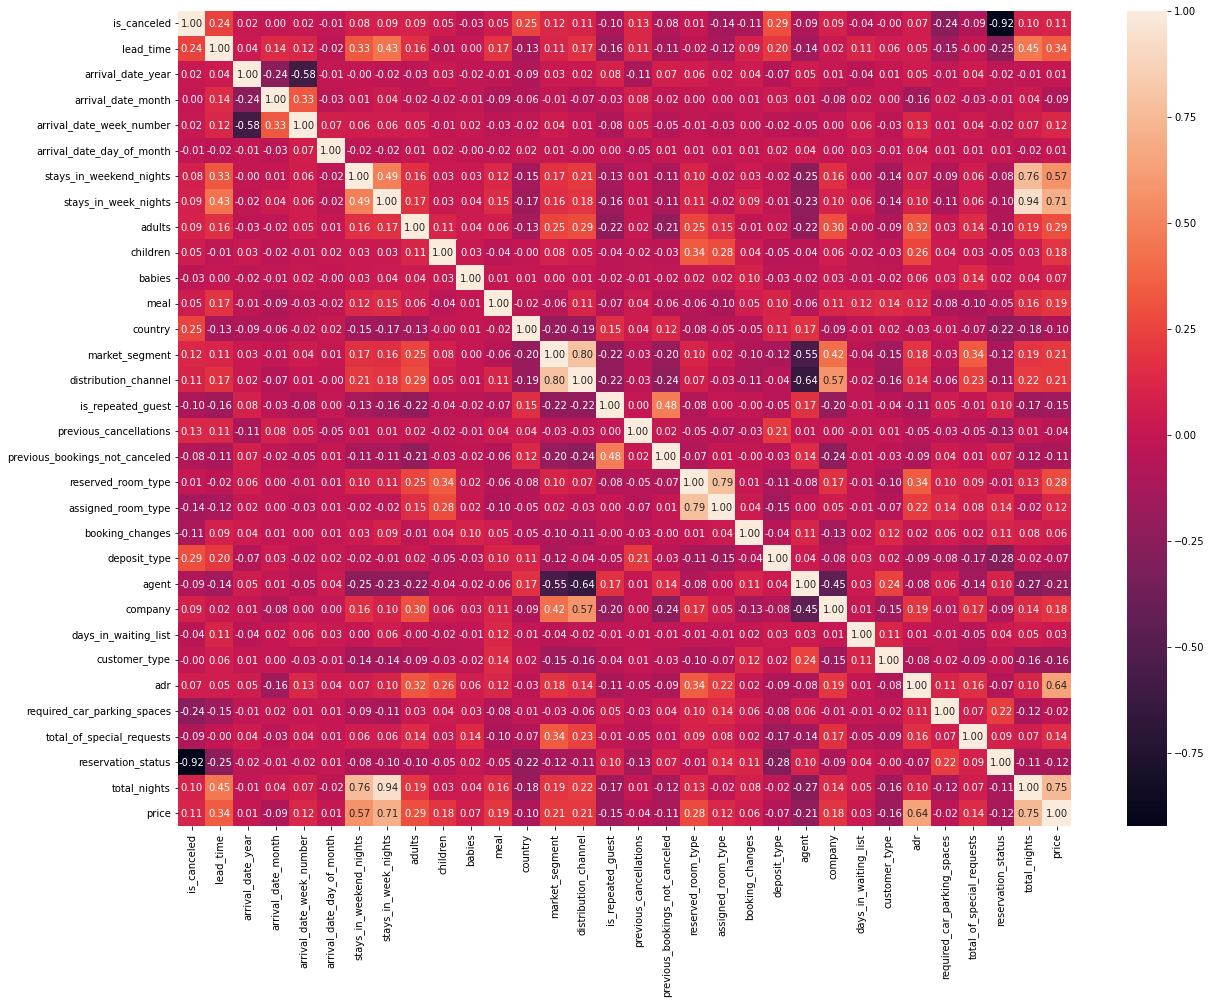

In [ ]:
plt.figure(figsize=(20, 15))
sns.heatmap(df_le.corr(), annot=True, fmt='.2f');



* There is high correlation between reservation_status and is_canceled
* And in the same, there is high correlation between total_nights and stays_in_week_nights
* And last one, between total_nights and stays_in_weekend_nights
* So, drop the reservation_status and total_nights
* And drop the reservation_status_date because of related between reservation_status



In [ ]:
columns = [
    'reservation_status_date',
    'total_nights',
    'reservation_status',
]

train = train.drop(columns, axis=1)
test = test.drop(columns, axis=1)
df_le = df_le.drop(columns, axis=1)

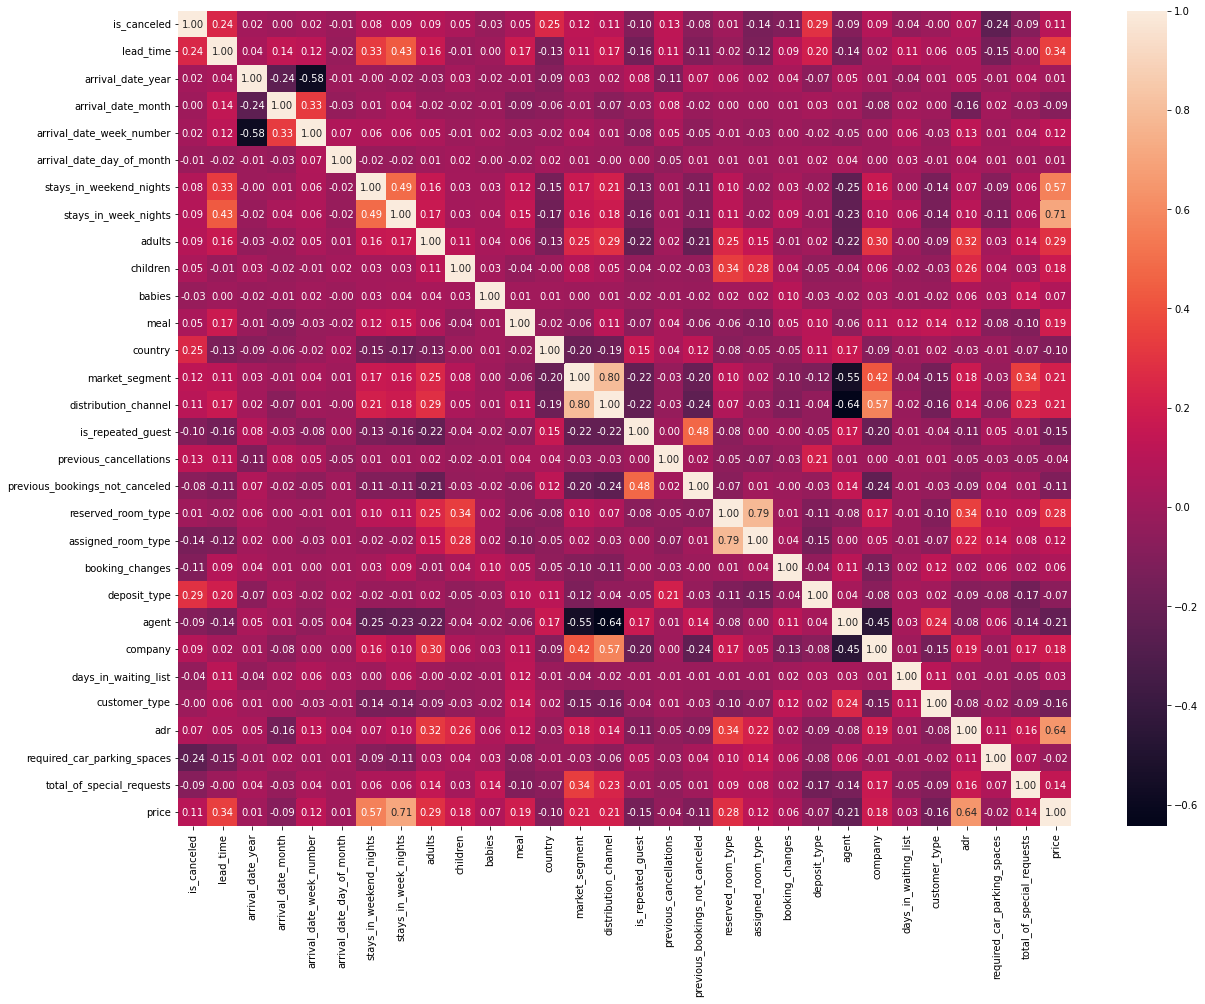

In [ ]:
plt.figure(figsize=(20, 15))
sns.heatmap(df_le.corr(), annot=True, fmt='.2f');

Dummy Variables vs Label Encoder

In [ ]:
new_categoricals = [col for col in categoricals if col in train.columns]
df_hot = pd.get_dummies(data=train, columns=new_categoricals)
test_hot = pd.get_dummies(data=test, columns=new_categoricals)
X_hot = df_hot.drop('is_canceled', axis=1)
X_le = df_le.drop('is_canceled', axis=1)
y = train['is_canceled']

Logistic regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_hot, y, test_size=.2, random_state=42)

log = LogisticRegression().fit(X_train, y_train)
y_pred = log.predict(X_test)
accuracy_score(y_test, y_pred)

0.8232572486119679

## Modelling

In [ ]:
class Report:
    def __init__(self, X_test, y_test):
        self.X = X_test
        self.y = y_test
    
    def metrics(self, model):
        y_pred = model.predict(self.X)
        
        print('Accuracy score:\n')
        print(accuracy_score(self.y, y_pred))
        
        print('\nConfusion Matrix:\n')
        print(confusion_matrix(self.y, y_pred))
        
        print('\nClassification Report:\n')
        print(classification_report(self.y, y_pred))
    
    def plot_roc_curve(self, model, part='h1', save=False):
        probs = model.predict_proba(self.X)
        preds = probs[:, 1]

        fpr, tpr, threshold = roc_curve(self.y, preds)
        roc_auc = auc(fpr, tpr)

        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        
        if save:
            name = model.__class__.__name__
            plt.savefig(f'./images/{name}_{part}.png')
        plt.show()

In [ ]:
report = Report(X_test, y_test)

Accuracy score:

0.8232572486119679

Confusion Matrix:

[[4517  223]
 [ 923  821]]

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      4740
           1       0.79      0.47      0.59      1744

    accuracy                           0.82      6484
   macro avg       0.81      0.71      0.74      6484
weighted avg       0.82      0.82      0.81      6484



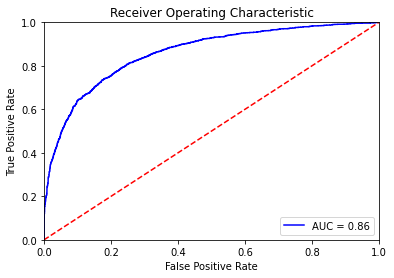

In [ ]:
log = LogisticRegression().fit(X_train, y_train)
report.metrics(log)
report.plot_roc_curve(log)

XGBoost Classifier

Accuracy score:

0.8878778531770513

Confusion Matrix:

[[4462  278]
 [ 449 1295]]

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      4740
           1       0.82      0.74      0.78      1744

    accuracy                           0.89      6484
   macro avg       0.87      0.84      0.85      6484
weighted avg       0.89      0.89      0.89      6484



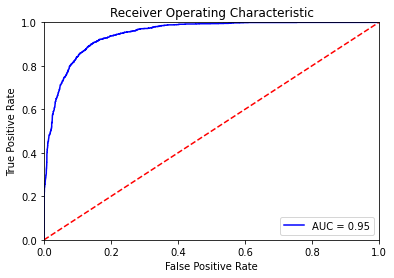

In [ ]:
xgb = XGBClassifier().fit(X_train, y_train)
report.metrics(xgb)
report.plot_roc_curve(xgb)